In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
project_dir = Path(os.path.abspath('')).resolve().parents[0]

#### Read in data

In [6]:
data = pd.read_csv(project_dir / 'data' / 'interim' / 'data_clean.csv', low_memory=False)

#### Prep train and test

In [7]:
features = data.drop('loan_status', axis=1).columns.values.tolist()
response = 'loan_status'

In [8]:
data[response].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [9]:
y = (data[response] != 'Fully Paid') + 0
X = data[features]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Fit Random Forest

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True)

In [12]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [13]:
feature_importance = pd.DataFrame({
    'Feature':X_train.columns.values.tolist(),
    'Importance':clf.feature_importances_.tolist()
})

In [14]:
feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
19,recoveries,0.232627
20,collection_recovery_fee,0.180792
16,total_rec_prncp,0.111621
13,out_prncp_inv,0.064853
12,out_prncp,0.063330
...,...,...
75,sub_grade_G3,0.000040
30,revol_util_na,0.000025
74,sub_grade_G2,0.000023
22,policy_code,0.000000


#### Plot

In [15]:
top_n = 10

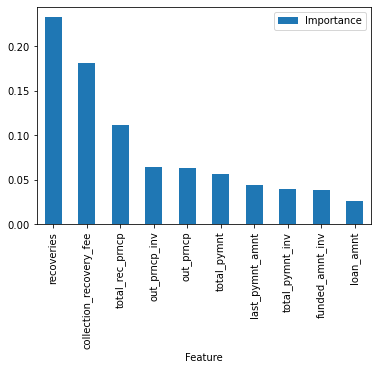

In [16]:
feature_importance.sort_values('Importance', ascending=False)[0:top_n].plot.bar(x='Feature', y='Importance')

#### Evaluate model

In [17]:
y_pred = clf.predict(X_test)

In [18]:
confusion_matrix(y_test, y_pred)

array([[6588,    0],
       [  38, 1318]], dtype=int64)

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(6588, 0, 38, 1318)

In [20]:
print(classification_report(y_test, y_pred, target_names = ['Fully Paid', 'Not Fully Paid']))

                precision    recall  f1-score   support

    Fully Paid       0.99      1.00      1.00      6588
Not Fully Paid       1.00      0.97      0.99      1356

      accuracy                           1.00      7944
     macro avg       1.00      0.99      0.99      7944
  weighted avg       1.00      1.00      1.00      7944



#### Output model and model matrices

In [21]:
out_file = open(project_dir / 'models' / "clf", "wb")
pickle.dump(clf, out_file)

In [22]:
data = {'X_train':X_train, 
        'X_test':X_test, 
        'y_train':y_train, 
        'y_test':y_test}

out_file = open(project_dir / 'data' / 'processed' / "datasets", "wb")
pickle.dump(data, out_file)